# Neural network

### Try to use our own preprocessing

In [109]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import sqlite3
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer
from time import time
from sklearn.decomposition import PCA
import warnings
from pathlib import Path

from utils.data_processing import create_feables
from utils.data_processing import confusion_matrix

warnings.simplefilter("ignore")

# You should run the ../../data_preprocessing.ipynb notebook to generate the data before running this
data = pd.read_csv("../../datasets/data.csv")
# data = data.tail(1000)

def normalize_bk_coefs(row, coef_name):
    keys = ['H', 'A', 'D']
    total = 0
    for key in keys:
        total += row[coef_name+key]
    
    for key in keys:
        row[coef_name+key] = row[coef_name+key] / total
    
    return row

# Normalize coefs
bk = ["B365", "BW", "IW", "LB", "WH", "VC"]
for coef_name in bk:
    data = data.apply(lambda row: normalize_bk_coefs(row, coef_name), axis=1)


labels = data.loc[:,'label']
features = data.drop('label', axis = 1)

print('Done')

Done


In [141]:
data = data.sort_values(['season', 'month'], ascending=(True, True))
test = data[(data['season'] == 2015) & (data['month'] > 8)]

y_test = test.loc[:, 'label']
X_test = test.drop('label', axis=1)

train = data[~data.isin(test)].dropna(how = 'all')
y_train = data.loc[:, 'label']
X_train = data.drop('label', axis=1)

In [142]:
from sklearn.model_selection import train_test_split
#Splitting the data into train, test
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.25, random_state = 42, shuffle = True, stratify = labels)

# Show some rows of the data
X_train.head()

ValueError: Found input variables with inconsistent numbers of samples: [19487, 3]

In [143]:
print("Number of wins in test set:", np.sum(y_test == 2))
print("Number of draws in test set:", np.sum(y_test == 1))
print("Number of defeats in test set:", np.sum(y_test == 0))

Number of wins in test set: 457
Number of draws in test set: 268
Number of defeats in test set: 325


In [144]:
# Match outcome
y_train.head()

# Number of possible outcomes
# 2 = win
# 1 = draw
# 0 = lose
print('Number of possible outcomes', np.unique(y_train.values).shape[0])
labels = np.unique(y_train.values)
print("Labels:", labels)


Number of possible outcomes 3
Labels: [0. 1. 2.]


In [114]:
# Get number of columns by getting the number of columns in the X_train
columns = X_train.shape[1]
print('Number of columns:', columns)

Number of columns: 35


### Train test split with the test set being the results of the last 3 months. 

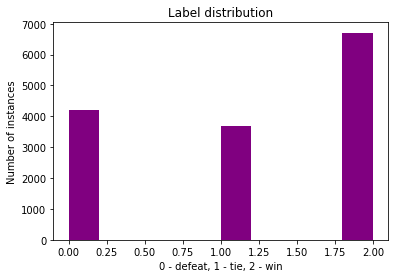

In [115]:
import matplotlib.pyplot as plt

# Plot the distribution of labels in the train data
def plot_labels_histogram(data):
    plt.hist(data, facecolor='purple', align='mid')
    plt.ylabel('Number of instances')
    plt.xlabel('0 - defeat, 1 - tie, 2 - win')
    plt.title("Label distribution")
    
plot_labels_histogram(y_train)

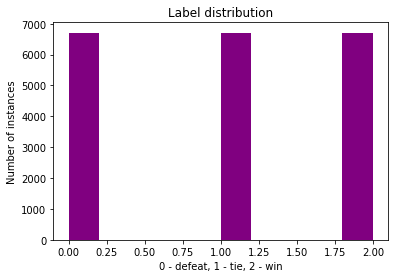

In [116]:
from imblearn.over_sampling import RandomOverSampler

# Since the train data is uneven and the dataset is not "huge" we need to upsamle/oversample
sampler = RandomOverSampler()
X_train_sampled, y_train_sampled = sampler.fit_sample(X_train, y_train)

# Plot the oversampled train set
plot_labels_histogram(y_train_sampled)

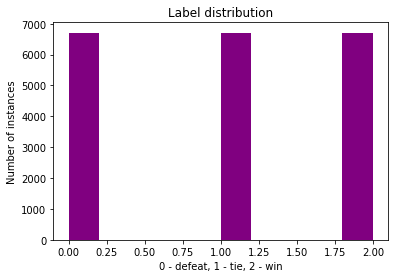

In [117]:
from sklearn.utils import shuffle

# Assign train values with the new sampled data
X_train, y_train = shuffle(X_train_sampled, y_train_sampled, random_state=42)

plot_labels_histogram(y_train)

In [118]:
from keras.models import Model, Sequential
from keras.layers import Input, Activation, Flatten, Dense, Dropout
from keras.optimizers import SGD, Adam
from keras import regularizers

def create_model(learning_rate=1e-5, dropout_rate=0.1):
    model = Sequential() 
    model.add(Dense(64, input_dim=columns, activation='tanh', kernel_regularizer='l2'))
    #model.add(Dropout(dropout_rate))
    #model.add(Dense(16, activation='relu', kernel_regularizer='l2'))
    model.add(Dropout(dropout_rate))
    #model.add(Dense(16, activation='relu', kernel_regularizer='l2'))
    #model.add(Dense(8, inputactivation='tanh', kernel_regularizer='l2'))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=learning_rate), metrics=['accuracy'])
    return model

In [119]:
from keras.utils.np_utils import to_categorical

# Convert a class vector (integers) to binary class matrix.
print("Unique labels in the train set: ", np.unique(y_train))
# One hot encoding
y_train_categorical = to_categorical(y_train, num_classes=len(labels))
print("Unique labels in the train set after encoding: ", np.unique(y_train_categorical, axis=0))

print("------------------------------------------------------------------------------ \n")


Unique labels in the train set:  [0. 1. 2.]
Unique labels in the train set after encoding:  [[0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]]
------------------------------------------------------------------------------ 



In [72]:
learning_rates = [1e-3, 5e-3, 1e-4, 5e-4, 1e-5, 1e-6]
dropout_rates = [0.05, 0.1, 0.2]

best_lr = None
best_dr = None

best_val_acc = 0
best_model = None
for lr in learning_rates:
    for dr in dropout_rates:
        print('Learning rate: {0}, Dropout rate: {1}'.format(lr, dr))
        model = create_model(lr, dr)
        history = model.fit(
            X_train,
            y_train_categorical,
            epochs=100,
            validation_split=0.1,
            verbose=0)
        val_acc = max(history.history['val_accuracy'])
        acc = max(history.history['accuracy'])
        print('Accuracy: {0}, Validation accuracy: {1}'.format(acc, val_acc))
        predictions = np.argmax(model.predict(X_test), axis=1)
        #print(np.unique(predictions))
        # Calculate accuracy
        accuracy = (predictions == y_test).mean()
        print("Test set accuracy:", accuracy)
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_lr = lr
            best_dr = dr
            best_model = model
            
            

print('Done')
        
        

Learning rate: 0.001, Dropout rate: 0.05
Accuracy: 0.34613898396492004, Validation accuracy: 0.34873324632644653
Test set accuracy: 0.2883825944170772
Learning rate: 0.001, Dropout rate: 0.1
Accuracy: 0.3469117283821106, Validation accuracy: 0.34873324632644653
Test set accuracy: 0.4591543513957307
Learning rate: 0.001, Dropout rate: 0.2
Accuracy: 0.344814270734787, Validation accuracy: 0.3522106409072876
Test set accuracy: 0.2524630541871921
Learning rate: 0.005, Dropout rate: 0.05
Accuracy: 0.33990174531936646, Validation accuracy: 0.34773969650268555
Test set accuracy: 0.4558702791461412
Learning rate: 0.005, Dropout rate: 0.1
Accuracy: 0.34238559007644653, Validation accuracy: 0.34873324632644653
Test set accuracy: 0.2524630541871921
Learning rate: 0.005, Dropout rate: 0.2
Accuracy: 0.3454214334487915, Validation accuracy: 0.34773969650268555
Test set accuracy: 0.2883825944170772
Learning rate: 0.0001, Dropout rate: 0.05
Accuracy: 0.34818127751350403, Validation accuracy: 0.3532041

In [73]:
best_lr

1e-05

In [34]:
best_dr

0.2

In [120]:
model = create_model(1e-05, 0.2)
history = model.fit(
            X_train,
            y_train_categorical,
            epochs=100,
            validation_split=0.1,
            verbose=1)
val_acc = max(history.history['val_accuracy'])
acc = max(history.history['accuracy'])
print('Accuracy: {0}, Validation accuracy: {1}'.format(acc, val_acc))

Train on 18117 samples, validate on 2013 samples
Epoch 1/100
18117/18117 [==============================] - 1s 37us/step - loss: 2.2808 - accuracy: 0.3294 - val_loss: 2.0818 - val_accuracy: 0.3284
Epoch 2/100
18117/18117 [==============================] - 1s 30us/step - loss: 2.0734 - accuracy: 0.3272 - val_loss: 1.8839 - val_accuracy: 0.3294
Epoch 3/100
18117/18117 [==============================] - 0s 26us/step - loss: 1.9228 - accuracy: 0.3282 - val_loss: 1.7358 - val_accuracy: 0.3299
Epoch 4/100
18117/18117 [==============================] - 0s 26us/step - loss: 1.8045 - accuracy: 0.3267 - val_loss: 1.6343 - val_accuracy: 0.3348
Epoch 5/100
18117/18117 [==============================] - 0s 26us/step - loss: 1.7220 - accuracy: 0.3324 - val_loss: 1.5614 - val_accuracy: 0.3333
Epoch 6/100
18117/18117 [==============================] - 0s 26us/step - loss: 1.6648 - accuracy: 0.3301 - val_loss: 1.5094 - val_accuracy: 0.3348
Epoch 7/100
18117/18117 [==============================] - 0s 2

Epoch 56/100
18117/18117 [==============================] - 0s 27us/step - loss: 1.2384 - accuracy: 0.3403 - val_loss: 1.1510 - val_accuracy: 0.3477
Epoch 57/100
18117/18117 [==============================] - 0s 27us/step - loss: 1.2404 - accuracy: 0.3385 - val_loss: 1.1504 - val_accuracy: 0.3517
Epoch 58/100
18117/18117 [==============================] - 0s 27us/step - loss: 1.2353 - accuracy: 0.3373 - val_loss: 1.1491 - val_accuracy: 0.3517
Epoch 59/100
18117/18117 [==============================] - 0s 27us/step - loss: 1.2263 - accuracy: 0.3429 - val_loss: 1.1491 - val_accuracy: 0.3517
Epoch 60/100
18117/18117 [==============================] - 0s 27us/step - loss: 1.2298 - accuracy: 0.3389 - val_loss: 1.1468 - val_accuracy: 0.3532
Epoch 61/100
18117/18117 [==============================] - 0s 27us/step - loss: 1.2358 - accuracy: 0.3373 - val_loss: 1.1465 - val_accuracy: 0.3616
Epoch 62/100
18117/18117 [==============================] - 0s 28us/step - loss: 1.2309 - accuracy: 0.3405

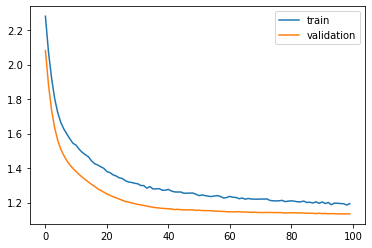

In [121]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

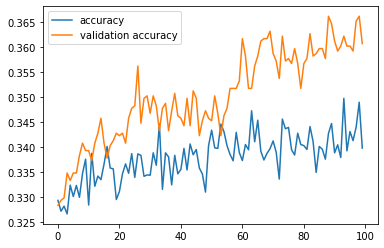

In [122]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.show()

In [123]:
# Take the most probable prediction
# print(model.predict(X_test))
predictions = np.argmax(model.predict(X_test), axis=1)
print(np.unique(predictions))
# Calculate accuracy
accuracy = (predictions == y_test).mean()
print("Test set accuracy:", accuracy)

[0 1 2]
Test set accuracy: 0.37787356321839083


# Let us plot the confusion matrix

1024
[0 1 2]
Neural network confusion matrix: 
                    Home wins (pred)  Draw (pred)  Home loses (pred)
Home wins (true)               1049          457                731
Draw (true)                     547          286                397
Home loses (true)               618          281                506

 True labels distribution: 



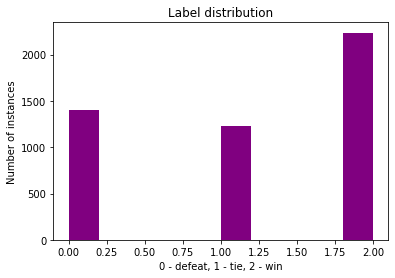

In [124]:
# from utils.data_processing import build_confusion_matrix

# TODO: Remove this and use the commented import instead
def build_confusion_matrix(y_true, y_pred):
    return pd.DataFrame(confusion_matrix(y_true, y_pred, labels=[2, 1, 0]),
                        index=['Home wins (true)', 'Draw (true)', 'Home loses (true)'],
                        columns=['Home wins (pred)', 'Draw (pred)', 'Home loses (pred)'])

print(np.sum((predictions == 1)))
print(np.unique(predictions))
print("Neural network confusion matrix: \n", build_confusion_matrix(y_test, predictions))


print('\n True labels distribution: \n')
plot_labels_histogram(y_test)

# Comparing Neural network to Random forest

In [125]:
#Splitting the data into Train, Calibrate, and Test data sets
#X_train_calibrate, X_test, y_train_calibrate, y_test = train_test_split(features, labels, test_size = 0.25, random_state = 0, stratify = labels)
X_train_calibrate = X_train
y_train_calibrate = y_train
X_train, X_calibrate, y_train, y_calibrate = train_test_split(X_train_calibrate, y_train_calibrate, test_size = 0.25, random_state = 0, stratify = y_train_calibrate)


In [134]:
from utils.data_processing import train_calibrate_predict

cross_validation_sets = model_selection.StratifiedShuffleSplit(n_splits = 5, test_size = 0.20, random_state = 5)
cross_validation_sets.get_n_splits(X_train, y_train)

random_forest = RandomForestClassifier(n_estimators = 200, random_state = 42, class_weight ='balanced')

feature_len = features.shape[1]
scorer = make_scorer(accuracy_score)
parameters_RF = {
    'clf__max_features': ['auto', 'log2'],
    'dm_reduce__n_components': np.arange(5, feature_len, int(np.around(feature_len/5)))
}

pca = PCA()
random_forest.fit(X_train, y_train)

print("Random forest accuracy for train set: ", accuracy_score(y_train, random_forest.predict(X_train)))
print("Random forest accuracy for test set: ", accuracy_score(y_test, random_forest.predict(X_test)))

#Grid search, calibrate, and test the classifier
calibrated_random_forest, dm_reduce, train_score, test_score = train_calibrate_predict(clf = random_forest, dm_reduction = pca, X_train = X_train, y_train = y_train,
                                                                                X_calibrate = X_calibrate, y_calibrate = y_calibrate,
                                                                                X_test = X_test, y_test = y_test, cv_sets = cross_validation_sets,
                                                                                params = parameters_RF, scorer = scorer, jobs = 1, use_grid_search = True)


Random forest accuracy for train set:  1.0
Random forest accuracy for test set:  0.5644499178981938
Training a RandomForestClassifier with PCA...
Trained RandomForestClassifier in 6.6 minutes
Calibrating probabilities of classifier...
Calibrated CalibratedClassifierCV in 0.0 minutes
Made predictions in 0.4607 seconds
Score of CalibratedClassifierCV for training set: 0.9996.
Made predictions in 0.1655 seconds
Score of CalibratedClassifierCV for test set: 0.5722.
Made predictions in 0.4622 seconds
Made predictions in 0.1702 seconds


In [135]:
rf_predictions = random_forest.predict(X_test)

# Calculate accuracy
accuracy = (rf_predictions == y_test).mean()
print("Random forest test set accuracy:", accuracy)

Random forest test set accuracy: 0.5644499178981938


In [136]:
print("Random forest confusion matrix: \n", build_confusion_matrix(y_test, rf_predictions))

Random forest confusion matrix: 
                    Home wins (pred)  Draw (pred)  Home loses (pred)
Home wins (true)               1531          377                329
Draw (true)                     396          504                330
Home loses (true)               369          321                715


# Conclusion

Random Forest Classifier is more effective in predicting football games

In [137]:
model.save('neural_network.h5')

In [138]:
from joblib import dump, load

dump(random_forest, 'Random_forest.joblib') 

['Random_forest.joblib']